In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from gpflow.utilities import print_summary, set_trainable, to_default_float
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '5'

from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime

import sys
sys.path.append('../../src')
from data_preparation import get_birth_data, separate_data, train_test_normalise
from useful_fun import plot_sliding_window, number_outof_CI, split_dataframe_by_position


In [2]:
# load data

# whole dataset
data = get_birth_data()
x, y = separate_data(data) # y is unnormalised: good!

# get date for x-axis in plots: mm-yyyy
def get_xticks(df):
    dff = df.groupby(by='m-y').first()
    pos = dff.ids; pos = pos[1:]
    labels = dff.index; labels = labels[1:]
    return pos, labels

2022-08-15 23:59:23.148502: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-15 23:59:23.742726: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9646 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:b2:00.0, compute capability: 7.5


# Sliding Window
### Simple one-latent function model with VGP

        y = f(x) + e
        f = GP(0, RBF)

        l = InvGama()
        sigma = Gamma()

In [3]:
def optimise_model(model, epochs=50):

    set_trainable(model.q_mu, False)
    set_trainable(model.q_sqrt, False)

    variational_vars = [(model.q_mu, model.q_sqrt)]
    natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)
    adam_vars = model.trainable_variables
    adam_opt = tf.optimizers.Adam(0.01)

    @tf.function
    def optimisation_step():
        natgrad_opt.minimize(model.training_loss, variational_vars)
        adam_opt.minimize(model.training_loss, adam_vars)

    for epoch in range(1, epochs + 1):
        optimisation_step()

In [6]:
def slidingwindow_alg(splits, window_size, epochs=50):    
    split_dataframes = split_dataframe_by_position(data, splits)

    # evaluation lists
    ELBO_train = []
    mse_train = []; mae_train = []; n_outof_CI_train = []
    mse_test = [];  mae_test = [];  n_outof_CI_test = []

    # window sizes
    iterations = splits-window_size

    # which iteration to plot
    iteration_plot = np.random.randint(low=0, high=iterations)
    print('iterations to go through, plot: ', iterations, iteration_plot)

    ls = []; vs = []

    for i in range(splits-window_size):
        # create new dataframe
        df = pd.DataFrame()

        # select data
        for df_ind in range(window_size):
            if df_ind == 0:
                df = split_dataframes[i]
            else :
                df = pd.concat([df, split_dataframes[i+df_ind]], axis=0)

        whole_data = pd.concat([df, split_dataframes[i+window_size]], axis=0)
        pos, labels = get_xticks(whole_data)

        # normalise & separate data
        df_train = df; df_test = split_dataframes[i+window_size]
        df_train, df_test = train_test_normalise(df_train, df_test)
        x_train, y_train = separate_data(df_train)
        x_test, y_test = separate_data(df_test)
        
        # build model
        if i == 0:
            kernel = gpflow.kernels.RBF(lengthscales = 7, variance = 1)
        else:
            # re-optimize from starting values = optimizes hyperparameters in previous window
            kernel = gpflow.kernels.RBF(lengthscales = l, variance = v)
        model = gpflow.models.VGP((x_train, y_train), kernel, gpflow.likelihoods.Gaussian(), num_latent_gps=1)
        set_trainable(model.likelihood.variance, False)
        model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
        model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))

        # optimise/train step
        optimise_model(model, epochs=epochs)

        # save hyperparameters
        l = model.kernel.lengthscales.numpy()
        v = model.kernel.variance.numpy()
        ls.append(l); vs.append(v)

        # predict
        mean_train, var_train = model.predict_y(x_train)
        mean_test, var_test = model.predict_y(x_test)

        # evaluate
        ELBO_train.append(model.elbo().numpy())
        mse_train.append(mean_squared_error(y_train, mean_train)); mae_train.append(mean_absolute_error(y_train, mean_train)); n_outof_CI_train.append(number_outof_CI(y_train, mean_train, var_train))
        mse_test.append(mean_squared_error(y_test, mean_test)); mae_test.append(mean_absolute_error(y_test, mean_test)); n_outof_CI_test.append(number_outof_CI(y_test, mean_test, var_test))

        if i == iteration_plot:
            plot_sliding_window(x_train, x_test, y_train, y_test, mean_train, mean_test, var_train, var_test, pos, labels, iteration=1)
        

    # Average evaluation metrics
    print('ELBO Avg: ', np.mean(ELBO_train))
    print('Train Avg. MSE, MAE, points outside CI: ', np.mean(mse_train), np.mean(mae_train), np.mean(n_outof_CI_train))
    print('Test Avg. MSE, MAE, points outside CI: ', np.mean(mse_test), np.mean(mae_test), np.mean(n_outof_CI_test))

    # histogram of CI
    fig, ax = plt.subplots(1,2)
    ax[0].hist(n_outof_CI_train, bins=50)
    ax[0].set_title('Train')
    ax[1].hist(n_outof_CI_test, bins=50)
    ax[1].set_title('Test')
    plt.title('Histogram of number of points that lie outside 95% CI')
    plt.show()

    # evolution of metrics
    fig, ax = plt.subplots(1,2, figsize=(8,4))
    ax[0].plot(np.linspace(1,iterations, iterations), mse_train, '-', color='C0')
    ax[0].plot(np.linspace(1,iterations, iterations), mse_test, '-', color='orange')
    ax[0].set_ylabel('MSE')
    ax[0].set_xlabel('Windows')
    ax[1].plot(np.linspace(1,iterations, iterations), mae_train, '-', color='C0', label='Train set')
    ax[1].plot(np.linspace(1,iterations, iterations), mae_test, '-', color='orange', label='Test set')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Windows')
    plt.legend()
    plt.show()

    # evolution of ls and vs
    fig, ax = plt.subplots(1,2, figsize=(8,4))
    ax[0].plot(np.linspace(1,iterations, iterations), ls, '-')
    ax[0].set_ylabel('lengthscales')
    ax[0].set_xlabel('Windows')
    ax[1].plot(np.linspace(1,iterations, iterations), vs, '-')
    ax[1].set_ylabel('variances')
    ax[1].set_xlabel('Windows')
    plt.show()

    return print_summary(model, fmt='notebook')

iterations to go through, plot:  116 73


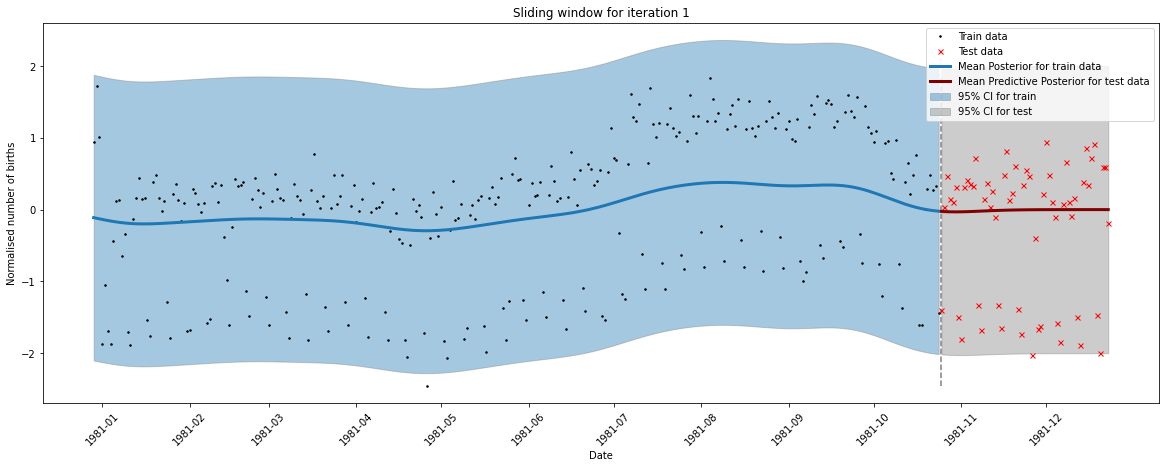

ELBO Avg:  -417.17705160988464
Train Avg. MSE, MAE, points outside CI:  0.8576145186457278 0.790244578126607 1.6896551724137931
Test Avg. MSE, MAE, points outside CI:  1.1337823010755455 0.8750771106996258 1.7586206896551724


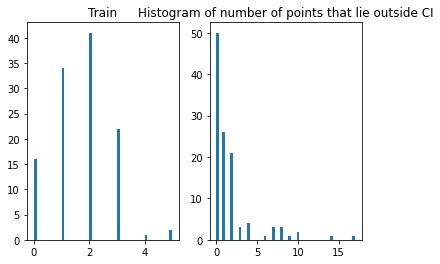

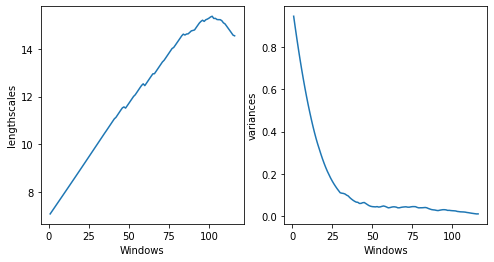

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,Gamma,True,(),float64,0.011657300096393878
VGP.kernel.lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,14.540864885839715
VGP.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1.0
VGP.num_data,Parameter,Identity,,False,(),int32,300
VGP.q_mu,Parameter,Identity,,False,"(300, 1)",float64,[[-0.31004558...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 300, 300)",float64,"[[[9.55756994e-01, 0.00000000e+00, 0.00000000e+00..."


: 

In [7]:
slidingwindow_alg(121, 5, epochs=10)

Train on 2yrs predict on 4months

In [ ]:
slidingwindow_alg(60, 6, epochs=10)

In [ ]:
slidingwindow_alg(60, 6, epochs=40)

In [ ]:
slidingwindow_alg(243, 11, epochs=20)

In [7]:
splits=121; window_size=5; epochs=10  
split_dataframes = split_dataframe_by_position(data, splits)

# evaluation lists
ELBO_train = []
mse_train = []; mae_train = []; n_outof_CI_train = []
mse_test = [];  mae_test = [];  n_outof_CI_test = []

# window sizes
iterations = splits-window_size

# which iteration to plot
iteration_plot = np.random.randint(low=0, high=iterations)
print('iterations to go through, plot: ', iterations, iteration_plot)

ls = []; vs = []

for i in range(splits-window_size):
    # create new dataframe
    df = pd.DataFrame()

    # select data
    for df_ind in range(window_size):
        if df_ind == 0:
            df = split_dataframes[i]
        else :
            df = pd.concat([df, split_dataframes[i+df_ind]], axis=0)

    whole_data = pd.concat([df, split_dataframes[i+window_size]], axis=0)
    pos, labels = get_xticks(whole_data)

    # normalise & separate data
    df_train = df; df_test = split_dataframes[i+window_size]
    df_train, df_test = train_test_normalise(df_train, df_test)
    x_train, y_train = separate_data(df_train)
    x_test, y_test = separate_data(df_test)
    
    # build model
    if i == 0:
        kernel = gpflow.kernels.RBF(lengthscales = 7, variance = 1)
        model = gpflow.models.VGP(tf.Variable((x_train, y_train)), kernel, gpflow.likelihoods.Gaussian(), num_latent_gps=1)
        set_trainable(model.likelihood.variance, False)
        model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
        model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))
    else:
        # update & re-optimize
        gpflow.models.vgp.update_vgp_data(model, tf.Variable(x_train, y_train))
        print_summary(model, fmt='notebook')

    # optimise/train step
    optimise_model(model, epochs=epochs)

    # save hyperparameters
    l = model.kernel.lengthscales.numpy()
    v = model.kernel.variance.numpy()
    ls.append(l); vs.append(v)

    # predict
    mean_train, var_train = model.predict_y(x_train)
    mean_test, var_test = model.predict_y(x_test)

    # evaluate
    ELBO_train.append(model.elbo().numpy())
    mse_train.append(mean_squared_error(y_train, mean_train)); mae_train.append(mean_absolute_error(y_train, mean_train)); n_outof_CI_train.append(number_outof_CI(y_train, mean_train, var_train))
    mse_test.append(mean_squared_error(y_test, mean_test)); mae_test.append(mean_absolute_error(y_test, mean_test)); n_outof_CI_test.append(number_outof_CI(y_test, mean_test, var_test))

    if i == iteration_plot:
        plot_sliding_window(x_train, x_test, y_train, y_test, mean_train, mean_test, var_train, var_test, pos, labels, iteration=1)
    

# Average evaluation metrics
print('ELBO Avg: ', np.mean(ELBO_train))
print('Train Avg. MSE, MAE, points outside CI: ', np.mean(mse_train), np.mean(mae_train), np.mean(n_outof_CI_train))
print('Test Avg. MSE, MAE, points outside CI: ', np.mean(mse_test), np.mean(mae_test), np.mean(n_outof_CI_test))

# histogram of CI
fig, ax = plt.subplots(1,2)
ax[0].hist(n_outof_CI_train, bins=50)
ax[0].set_title('Train')
ax[1].hist(n_outof_CI_test, bins=50)
ax[1].set_title('Test')
plt.title('Histogram of number of points that lie outside 95% CI')
plt.show()

# evolution of metrics
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].plot(np.linspace(1,iterations, iterations), mse_train, '-', color='C0')
ax[0].plot(np.linspace(1,iterations, iterations), mse_test, '-', color='orange')
ax[0].set_ylabel('MSE')
ax[0].set_xlabel('Windows')
ax[1].plot(np.linspace(1,iterations, iterations), mae_train, '-', color='C0', label='Train set')
ax[1].plot(np.linspace(1,iterations, iterations), mae_test, '-', color='orange', label='Test set')
ax[1].set_ylabel('MAE')
ax[1].set_xlabel('Windows')
plt.legend()
plt.show()

# evolution of ls and vs
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].plot(np.linspace(1,iterations, iterations), ls, '-')
ax[0].set_ylabel('lengthscales')
ax[0].set_xlabel('Windows')
ax[1].plot(np.linspace(1,iterations, iterations), vs, '-')
ax[1].set_ylabel('variances')
ax[1].set_xlabel('Windows')
plt.show()

print_summary(model, fmt='notebook')

iterations to go through, plot:  116 37


OperatorNotAllowedInGraphError: in user code:

    File "/tmp/ipykernel_64618/4018919637.py", line 13, in optimisation_step  *
        natgrad_opt.minimize(model.training_loss, variational_vars)
    File "/home/cn321/.local/lib/python3.8/site-packages/gpflow/optimizers/natgrad.py", line 180, in minimize  *
        self._natgrad_steps(loss_fn, parameters)
    File "/home/cn321/.local/lib/python3.8/site-packages/gpflow/optimizers/natgrad.py", line 201, in _natgrad_steps  *
        loss = loss_fn()
    File "/home/cn321/.local/lib/python3.8/site-packages/gpflow/models/training_mixins.py", line 60, in training_loss  *
        return self._training_loss()  # type: ignore
    File "/home/cn321/.local/lib/python3.8/site-packages/gpflow/models/model.py", line 54, in _training_loss  *
        return -(self.maximum_log_likelihood_objective(*args, **kwargs) + self.log_prior_density())
    File "/home/cn321/.local/lib/python3.8/site-packages/gpflow/models/vgp.py", line 98, in maximum_log_likelihood_objective  *
        return self.elbo()
    File "/home/cn321/.local/lib/python3.8/site-packages/gpflow/models/vgp.py", line 112, in elbo  *
        X_data, Y_data = self.data

    OperatorNotAllowedInGraphError: iterating over `tf.Tensor` is not allowed: AutoGraph did convert this function. This might indicate you are trying to use an unsupported feature.
